In [36]:
# import orders_analysis
# import order_pipeline
import src.pipeline_courier_data
# import orders_merge

import pandas as pd
import numpy as np
import xgboost as xgb

import time
import os
import pickle

import plotly_express as px
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.display.max_columns = 500
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
with open('/home/ubuntu/ba_project/project_1_prod/first_import_output_050219','rb') as f:
    orders = pickle.load(f)
    f.close()

In [37]:
courier_demos = src.pipeline_courier_data.process_df('/home/ubuntu/ba_project/CourierData.xls')

WARNING *** file size (1649259) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
birth decade added
start-date info added
DONE


In [38]:
#Model creation and manipulation class

class Model_Creation(object):
    
    
    """
    
    this should contain all the necessary ingredients for creating the models.
    First, we need to define a split in the data.
    Second, we need to fit the models.
    Third, we need to pickle and return the models (both)
    Fourth, we need to pickle and return the split sets, or at least, the test sets, for additional testing
    
    """
    
    def __init__(self,df):
        self.df = df
        droplist = ['CareerTotalDaysWorked', 'CareerTotalDeliveries','churned','churned_2weeks','DepartDate','ID','firstPickup','lastPickup','firstmonth',
                   'PackageCharge','DefaultDrvComm','ClientRefNo3','ClientRefNo2','Caller','toValidate',
                    'InsuranceCharge','DrvSurcharge', 'VehicleId','trip_delay','trip_time','WarehousingCharge']
        self.droplist = droplist
        from sklearn.model_selection import train_test_split
        self.tts = train_test_split
        import pandas as pd
        self.pd = pd

    
    def other_vars(self,new_hire,courier_demos):
        self.new_hire = new_hire
        self.courier_demos = courier_demos
    
    def random_split(self):
        import orders_merge
        FM,AH,churn_tracking = orders_merge.middle_process(self.df,self.new_hire)
        final_first_month_orders = orders_merge.final_process(FM,self.new_hire,self.courier_demos,churn_tracking)
        final_all_history_orders = orders_merge.final_process(AH,self.new_hire,self.courier_demos,churn_tracking)
    
        ah_y = final_all_history_orders['churned']
        ah_x = final_all_history_orders.drop(self.droplist,axis=1)
        
        fm_y = final_first_month_orders['churned']
        fm_x = final_first_month_orders.drop(self.droplist,axis=1)
        
        self.ah_xtrain_random,self.ah_xtest_random,self.ah_ytrain_random,self.ah_ytest_random = self.tts(ah_x,ah_y)
        self.fm_xtrain_random,self.fm_xtest_random,self.fm_ytrain_random,self.fm_ytest_random = self.tts(fm_x,fm_y)
        
        

    def date_split(self,year,month,day):
        import src.orders_merge
        self.om=orders_merge
        
        FM,AH, churn_tracking= self.om.middle_process(self.df,self.new_hire)
        self.ah = AH
        self.churn_tracking = churn_tracking
        
       
        FM_train = FM.loc[FM['firstPickup'] < self.pd.Timestamp(year=year,month=month,day=day)]
        FM_test = FM.loc[FM['firstPickup'] > self.pd.Timestamp(year=year,month=month,day=day)]
        
        AH_train = AH.loc[AH['firstPickup'] < self.pd.Timestamp(year=year,month=month,day=day)]
        AH_test = AH.loc[AH['firstPickup'] > self.pd.Timestamp(year=year,month=month,day=day)]
        
        final_first_month_orders_train = self.om.final_process(FM_train,self.new_hire,self.courier_demos,churn_tracking)
        final_all_history_orders_train = self.om.final_process(AH_train,self.new_hire,self.courier_demos,churn_tracking)
        
#         FM_test,AH_test,churn_tracking_test = orders_merge.middle_process(test,self.new_hire)
        final_first_month_orders_test = self.om.final_process(FM_test,self.new_hire,self.courier_demos,churn_tracking)
        final_all_history_orders_test = self.om.final_process(AH_test,self.new_hire,self.courier_demos,churn_tracking)

        #First-month train and test sets
        self.fm_xtrain_date = final_first_month_orders_train.drop(self.droplist,axis=1)
        self.fm_xtest_date = final_first_month_orders_test.drop(self.droplist,axis=1)
        
        self.fm_ytrain_date = final_first_month_orders_train['churned']
        self.fm_ytest_date = final_first_month_orders_test['churned']
        
        #all-history train and test sets
        self.ah_xtrain_date = final_all_history_orders_train.drop(self.droplist,axis=1)
        self.ah_xtest_date = final_all_history_orders_test.drop(self.droplist,axis=1)
        
        self.ah_ytrain_date = final_all_history_orders_train['churned']
        self.ah_ytest_date = final_all_history_orders_test['churned']
        
        #save date-separated DFs for visualization
        self.fm_train = final_first_month_orders_train
        self.fm_test = final_first_month_orders_test
        
        self.processed_df = self.pd.concat([final_first_month_orders_train,final_first_month_orders_test],
                                            keys=['train','test'])
        
        
    def create_model_random_split(self):
        import xgboost as xgb
        self.fm_params = {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 100, 'subsample': 0.3, 
             'n_estimators':100,'learning_rate':0.2, 'max_features': 'sqrt',
                }
        
        self.xgboost_fm_random= xgb.XGBClassifier(**self.fm_params)
        self.fm_random_fitted = self.xgboost_fm_random.fit(self.fm_xtrain_random,self.fm_ytrain_random)

        
        self.xgboost_ah_random= xgb.XGBClassifier(**self.fm_params)
        self.ah_random_fitted = self.xgboost_ah_random.fit(self.ah_xtrain_random,self.ah_ytrain_random)

        
        
        
    def create_model_date_split(self):
        import xgboost as xgb
        self.fm_params = {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 100, 'subsample': 0.3, 
             'n_estimators':100,'learning_rate':0.2, 'max_features': 'sqrt',
                }

        self.xgboost_fm_datesplit= xgb.XGBClassifier(**self.fm_params)
        self.fm_datesplit_fitted = self.xgboost_fm_datesplit.fit(self.fm_xtrain_date,self.fm_ytrain_date)

        self.xgboost_ah_datesplit= xgb.XGBClassifier(**self.fm_params)
        self.ah_datesplit_fitted = self.xgboost_ah_datesplit.fit(self.ah_xtrain_date,self.ah_ytrain_date)


In [5]:
mc = Model_Creation(orders)

mc.other_vars('t',courier_demos)

mc.random_split()

mc.date_split(2016,1,1)

In [6]:
mc.create_model_random_split()

print('ah score',mc.ah_random_fitted.score(mc.ah_xtest_random,mc.ah_ytest_random))

print('fm score',mc.fm_random_fitted.score(mc.fm_xtest_random,mc.fm_ytest_random))

ah score 0.9128919860627178
fm score 0.926829268292683


In [7]:
mc.create_model_date_split()

print('ah score',mc.ah_datesplit_fitted.score(mc.ah_xtest_date,mc.ah_ytest_date))

print('fm score',mc.fm_datesplit_fitted.score(mc.fm_xtest_date,mc.fm_ytest_date))

ah score 0.8278008298755186
fm score 0.8278008298755186


In [8]:
#ORDERS ANALYSIS

def make_scores(testdf):
    with open('XGBoost_FM_1','rb') as f:
        xgbFM = pickle.load(f)
        f.close()
    with open('XGBoost_ah_1','rb') as f:
        xgbAH = pickle.load(f)
        f.close()
    
    ahscores = xgbAH.predict_proba(testdf)
    fmscores = xgbFM.predict_proba(testdf)
    
    superscores = (ahscores * .7) + (fmscores * .3)
    
    print_supers = np.around(superscores[:,1],decimals=3)
    tc = testdf.copy()
    tc['risk_scores'] = print_supers
    print('all risk levels:')
    print('\t ID \t \t risk level')
    for row in tc.itertuples(index=True):
        print('\t' , row[0], '\t', np.around(row.risk_scores,decimals=2))
    
    print('HIGH RISK LEVELS:')
    print('\t ID \t \t risk level')
    for row in tc.itertuples(index=True):
        if row.risk_scores > .6:
            print('\t' , row[0], '\t', np.around(row.risk_scores,decimals=2))
    
    return tc



#om = one-month data, ah = all-hsitory data
def process_df():
    
    om, ah = orders_merge.process_df()
    time.sleep(1)
    
    testdf=om.drop(['CareerTotalDaysWorked','CareerTotalDeliveries','ID'],axis=1)
    
    with open('XGBoost_FM_1','rb') as f:
        xgbFM = pickle.load(f)
        f.close()
    with open('XGBoost_ah_1','rb') as f:
        xgbAH = pickle.load(f)
        f.close()
    
    ahscores = xgbAH.predict_proba(testdf)
    fmscores = xgbFM.predict_proba(testdf)
    
    superscores = (ahscores * .7) + (fmscores * .3)
    
    print_supers = np.around(superscores[:,1],decimals=3)
#     tc = testdf.copy()
    om['risk_scores'] = print_supers
    print('all risk levels:')
    print('\t ID \t \t risk level')
    for row in om.itertuples(index=True):
        print('\t' , row[0], '\t', np.around(row.risk_scores,decimals=2))
    
    print('HIGH RISK LEVELS:')
    print('\t ID \t \t risk level')
    for row in om.itertuples(index=True):
        if row.risk_scores > .6:
            print('\t' , row[0], '\t', np.around(row.risk_scores,decimals=2))
    
    return om

In [32]:
#PRINT HIGHLY CORRELATED FEATURES AND THEIR LABELS FROM THE CORR MATRIX DF
def corr_highlights(dataset,cor_type='pearson',thresh=0.5):
    corr = dataset.corr(cor_type)
    for i in corr.iterrows():
        for j in i[1:]:
            for inx,k in enumerate(j):
                if (np.abs(k) > thresh) and (np.abs(k) !=1):
                    print(i[0],j.index[inx],k)

In [33]:
corr_highlights(mc.ah_xtrain_date,'kendall',0.7)

WeightCharge is_bike -0.7565808370593662
WeightCharge is_trucking 0.7700023452649313
state_is_NJ state_is_NY -0.8241758241758242
state_is_NY state_is_NJ -0.8241758241758242
is_bike WeightCharge -0.7565808370593662
is_bike is_trucking -0.9828417685589875
is_trucking WeightCharge 0.7700023452649313
is_trucking is_bike -0.9828417685589875


In [9]:
#credit for an earlier version of this function: currently lost, but if this looks like you, let me know!

def printFeatureImportance_2(alg,predictors,scale=2,indstart=0,indend=10):
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        trunk = feat_imp.iloc[indstart:indend].copy()
        trunk.plot.barh(figsize=(4*scale,4*scale),fontsize=(12*scale))
        plt.suptitle('First-month Performance Feature Importance Scores',fontsize=(18*scale))
        plt.xlabel('Feature Importance Score',fontsize=(15*scale))
#         plt.savefig('onemonth_feature_importances_{}_to_{}'.format(indstart,indend),
#                     orientation='landscape',dpi=720,
#                    bbox_inches='tight',pad_inches=3
#                    )

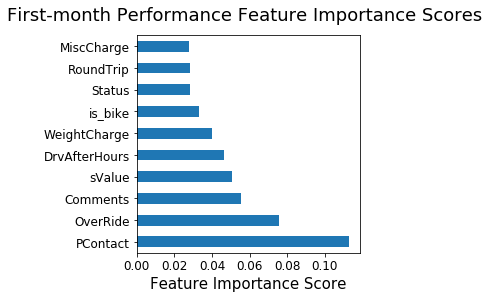

In [10]:
printFeatureImportance_2(mc.fm_datesplit_fitted,mc.fm_xtrain_date.columns,scale=1)

In [11]:
churned_table = mc.processed_df.groupby('churned').agg('mean').T
churned_table.columns=['not_churned','churned']

In [12]:
churned_table['diff'] = (churned_table['not_churned'] - churned_table['churned'])/(churned_table['not_churned'] + churned_table['churned'])
churned_table['abs_diff'] = np.abs((churned_table['not_churned'] - churned_table['churned'])/(churned_table['not_churned'] + churned_table['churned']))
churned_table['churn_greater'] = churned_table['diff'] !=churned_table['abs_diff']

# churned employees have:

### significantly higher (.1-.3 absolute difference in averages or greater): 
sValue


WeightCharge


Comments

State is other, CT, or NJ

WeightCharge




### Slightly higher (.05-.09):

Later start quarter (later in the year, especially fall)

is_bike (is a biker vehicleID type)

Comments present

OverRdie present


### significantly lower (.4-.9 difference in averages):
MiscCharge

sPieces


PackageCharge

is_amazon_or_fk (hired as an amazon or foodkick courier)


driver_extra_charges_avg


DrvSurcharge


DrvPackage


I classed "significance" on two different scales for each grouping because the number of features wherein churned was greater than not churned far outnumbered, and were of a greater magnitude, than vice versa.

For a more technical analysis, we would look at the mean of the average mean difference and define significance in terms of standard deviations from the mean.

Note: some of this analysis was done without eliminating high-covariance variables.

In [16]:
churned_table.sort_values('abs_diff',ascending=False).iloc[0:20,:]

,not_churned,churned,diff,abs_diff,churn_greater
state_is_Unknown,0.002937,0.000000,1.000000,1.000000,False
CODCharge,0.000004,0.000000,1.000000,1.000000,False
WarehousingCharge,0.000031,0.000000,1.000000,1.000000,False
TollCharge,0.000002,0.000000,1.000000,1.000000,False
HourlyCharge,0.000001,0.000000,1.000000,1.000000,False
churned_2weeks,0.000000,0.649462,-1.000000,1.000000,True
DrvStopOffExtras,0.000116,0.000000,1.000000,1.000000,False
CareerTotalDaysWorked,408.325991,6.978495,0.966393,0.966393,False
CareerTotalDeliveries,2711.340675,53.075269,0.961601,0.961601,False
MiscCharge,0.091643,0.002585,0.945139,0.945139,False


In [17]:
print(mc.fm_datesplit_fitted.score(mc.fm_xtest_date,mc.fm_ytest_date))

0.8278008298755186


In [18]:
ytrue = mc.fm_ytest_date
ypred = mc.fm_datesplit_fitted.predict(mc.fm_xtest_date)

print(classification_report(ytrue, ypred))
print(np.unique(ypred,return_counts=True))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       255
           1       0.96      0.66      0.78       227

   micro avg       0.83      0.83      0.83       482
   macro avg       0.86      0.82      0.82       482
weighted avg       0.86      0.83      0.82       482

(array([0, 1]), array([326, 156]))


In [19]:
#credit for this function: 
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[i] for i in unique_labels(ytrue,ypred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

#from sklearn plot confusion matrix example

Confusion matrix, without normalization
[[249   6]
 [ 77 150]]


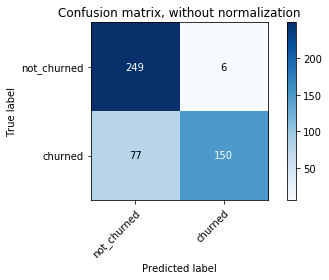

In [20]:
# Plot non-normalized confusion matrix
cl = {0: 'not_churned',1:'churned'}
plot_confusion_matrix(ytrue, ypred, classes = {0: 'not_churned',1:'churned'},
                      title='Confusion matrix, without normalization')

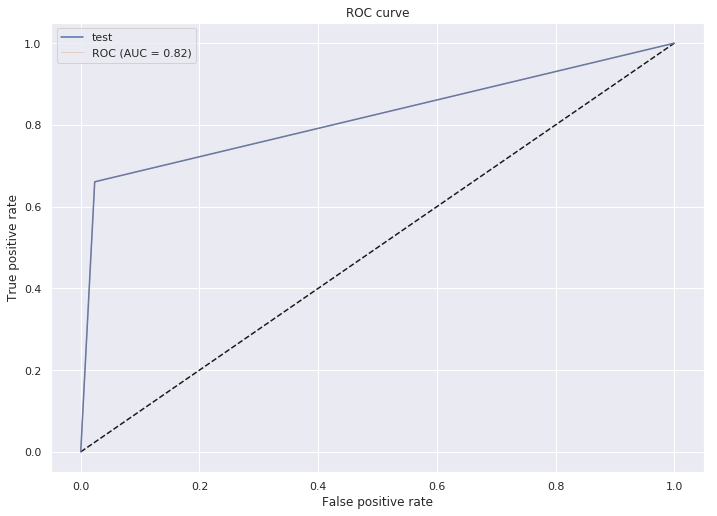

In [35]:
fpr, tpr, _ = roc_curve(ytrue, ypred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr, tpr, label='test')
aucs=[]
roc_auc = auc(fpr, tpr)
aucs.append(roc_auc)
plt.plot(fpr, tpr, lw=1, alpha=0.3,
label='ROC (AUC = %0.2f)' % (roc_auc))


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#credit for a version of this plot: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py


In [54]:
xvar = 'VehicleId'
yvar = 'CareerTotalDaysWorked'
dataset = mc.processed_df.loc[('train'),:]


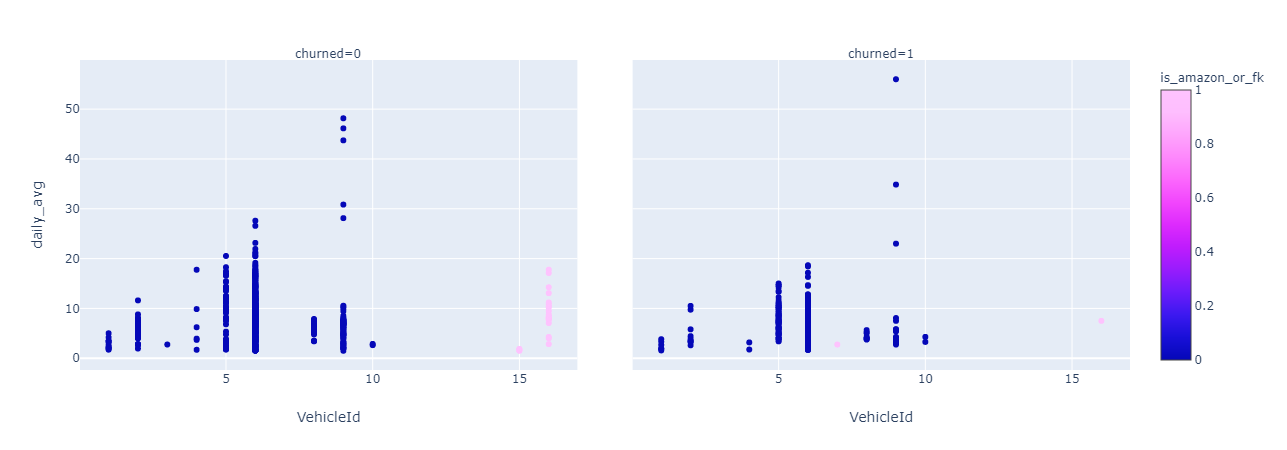

In [61]:
px.scatter(dataset, x='VehicleId', y='daily_avg', 
           color="is_amazon_or_fk", 
#            size="churned", size_max=20,
          hover_name="ID", 
           facet_col="churned", 
           log_x=False, log_y=False)


In [64]:
churned_true = dataset[dataset['churned']==1]

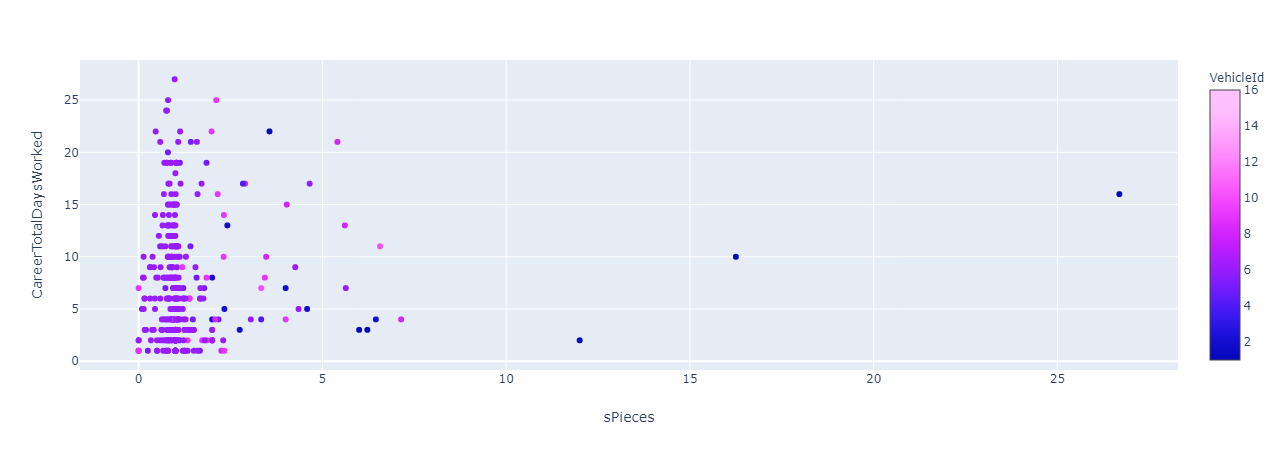

In [66]:
px.scatter(churned_true, x='sPieces', y='CareerTotalDaysWorked', 
           color="VehicleId", 
#            size="CareerTotalDeliveries", size_max=60,
          hover_name="ID", 
#            facet_col="churned",
              log_x=False)

Seems that we need to eliminate a few outliers!